# Training file for RDN

## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()

if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

from rdn import RDN

print(device)

privateuseone:0


# Utility function

In [2]:
class SuperResolutionStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(SuperResolutionStatsManager, self).__init__()

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d)
        # Updating `self.running_psnr`
        self.running_psnr += metrics.peak_signal_noise_ratio(d.detach().to('cpu').numpy(), y.detach().to('cpu').numpy())
    
    def summarize(self):
        loss = super(SuperResolutionStatsManager, self).summarize()
        psnr = self.running_psnr / (self.number_update+1e-9 )
        return {'loss': loss, 'psnr': psnr}

def criterion(y, d):
    return F.mse_loss(y, d)

#show image
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    # ax.axis('off')
    return h

## Data loader

In [4]:
#new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import your datasetclass
from lowhighresimagedataset import LowAndHighResImageDataset

X_train = LowAndHighResImageDataset(transform=train_transform, train=True)
X_valid = LowAndHighResImageDataset(transform=valid_transform, train=False)
X_train.get_info()

#train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
#valid_loader = DataLoader(X_valid, batch_size=32, shuffle=True)

Number of train low resolution images: 800
Number of train high resolution images: 800
Number of valid low resolution images: 200
Number of valid high resolution images: 200


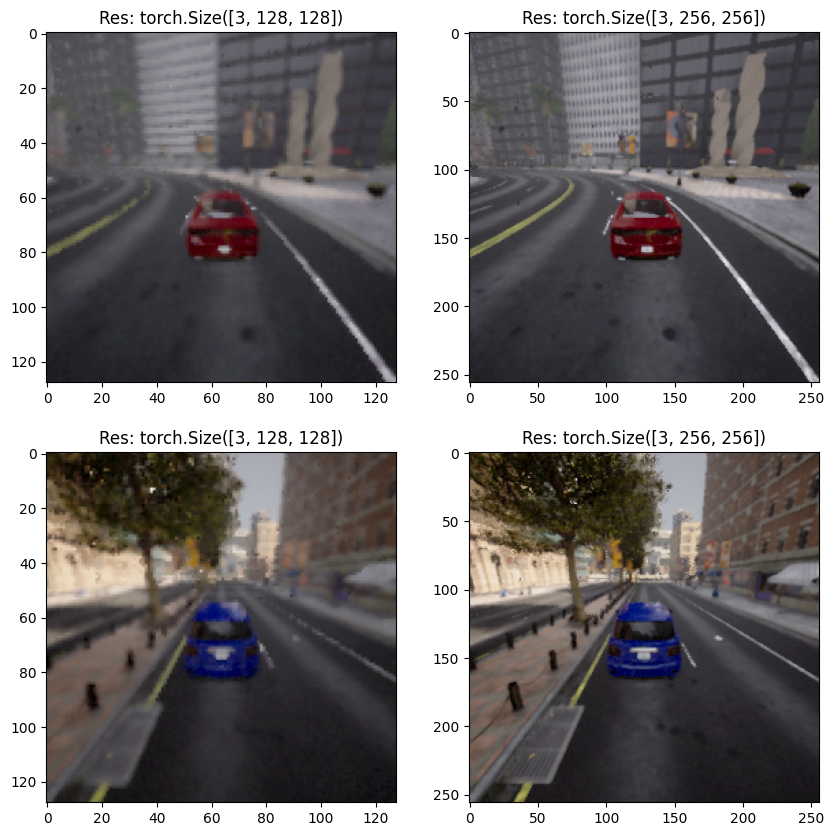

In [6]:
#printing some 2 pairs of low res/high res images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ex_low_res1, ex_high_res1 = X_train[np.random.randint(len(X_train))]
ex_low_res2, ex_high_res2 = X_train[np.random.randint(len(X_train))]
ex = [ex_low_res1, ex_high_res1, ex_low_res2, ex_high_res2]
for i, ax in enumerate(axes.flat):
    ax.set_title(f'Res: {ex[i].shape}')
    myimshow(ex[i], ax=ax)

## Experiment on a small batch

In [7]:
batch_size = 10
X_train_batch = [X_train[np.random.randint(len(X_train))] for _ in range(batch_size)]
lr = 1e-3
r = RDN(C=3 , D=10, G=16, G0=16, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
exp = nt.Experiment(r, X_train_batch, None, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir="../results/smallbatchexperiement5111", perform_validation_during_training=False)

In [8]:
exp.run(num_epochs=50, plot=None)

Start/Continue training from epoch 0
Epoch 1 (Time: 1.02s) Loss: 0.08170 psnr: 10.877675054894576
Epoch 2 (Time: 0.30s) Loss: 0.08061 psnr: 10.936352655498599
Epoch 3 (Time: 0.35s) Loss: 0.07879 psnr: 11.035017768486936
Epoch 4 (Time: 0.65s) Loss: 0.07522 psnr: 11.236621904429247
Epoch 5 (Time: 0.52s) Loss: 0.06964 psnr: 11.571236497299434
Epoch 6 (Time: 0.52s) Loss: 0.06384 psnr: 11.948845359339007
Epoch 7 (Time: 0.32s) Loss: 0.05988 psnr: 12.227127309730479
Epoch 8 (Time: 0.32s) Loss: 0.05140 psnr: 12.890622695505511
Epoch 9 (Time: 0.32s) Loss: 0.04500 psnr: 13.468082145467907
Epoch 10 (Time: 0.32s) Loss: 0.03311 psnr: 14.800424265330037
Epoch 11 (Time: 0.32s) Loss: 0.02388 psnr: 16.219590468380193
Epoch 12 (Time: 0.32s) Loss: 0.01522 psnr: 18.176697591208185
Epoch 13 (Time: 0.32s) Loss: 0.01627 psnr: 17.885766149201345
Epoch 14 (Time: 0.32s) Loss: 0.01845 psnr: 17.339722554450383
Epoch 15 (Time: 0.32s) Loss: 0.02042 psnr: 16.899040297864783
Epoch 16 (Time: 0.31s) Loss: 0.02052 psnr:

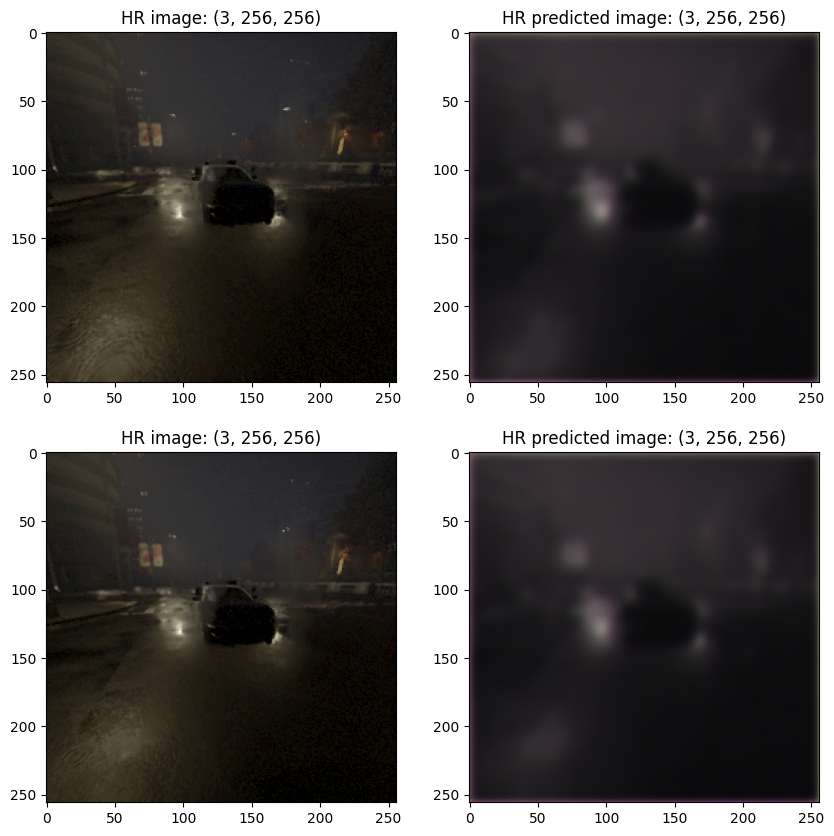

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
train_low_res1, train_high_res1 = X_train_batch[np.random.randint(len(X_train_batch))]
train_low_res2, train_high_res2 = X_train_batch[np.random.randint(len(X_train_batch))]
pred_high_res1 = exp.net(train_low_res1.to(device))[0]
pred_high_res2 = exp.net(train_low_res2.to(device))[0]
ex = [train_high_res1, pred_high_res1, train_high_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'HR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)

# Training the data

In [12]:
train_size = int(0.8 * len(X_train))
valid_size = len(X_train) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(X_train, [train_size, valid_size])
lr = 1e-3
batch_size = 10
r = RDN(C=3 , D=10, G=16, G0=16, scaling_factor=2, kernel_size=3, c_dims=X_train[0][0].shape[0], upscaling='shuffle', weights=None)
r = r.to(device)
adam = torch.optim.Adam(r.parameters(), lr=lr)
stats_manager = SuperResolutionStatsManager()
exp1 = nt.Experiment(r, train_dataset, valid_dataset, adam, stats_manager, device, criterion, batch_size=batch_size,
                     output_dir="../results/superresol145", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 (Time: 23.11s) Loss: 0.01654 psnr: 21.761039587104214
Epoch 2 (Time: 22.70s) Loss: 0.00584 psnr: 23.17218730005864
Epoch 3 (Time: 22.82s) Loss: 0.00481 psnr: 23.65313558359354
Epoch 4 (Time: 22.88s) Loss: 0.00418 psnr: 24.51602261805252
Epoch 5 (Time: 22.71s) Loss: 0.00393 psnr: 24.737782221967016
Epoch 6 (Time: 22.81s) Loss: 0.00353 psnr: 24.926699662915308
Epoch 7 (Time: 22.81s) Loss: 0.00344 psnr: 24.927019694623834
Epoch 8 (Time: 22.79s) Loss: 0.00332 psnr: 24.898117762318797
Epoch 9 (Time: 22.81s) Loss: 0.00335 psnr: 25.19027615362147
Epoch 10 (Time: 23.09s) Loss: 0.00322 psnr: 25.29039865165795
Finish training for 10 epochs


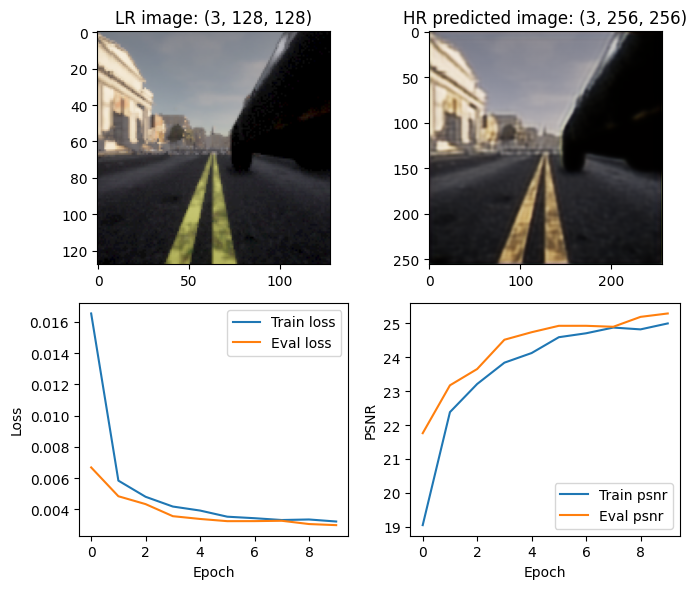

In [13]:
def plot(exp, fig, axes, low_res): ##Only to use when perform_validation_during_training == True
    with torch.no_grad():
        high_res = exp.net(low_res)[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(low_res, ax=axes[0][0])
    axes[0][0].set_title(f'LR image: {low_res.detach().cpu().numpy().shape}')
    myimshow(high_res, ax=axes[0][1])
    axes[0][1].set_title(f'HR predicted image: {high_res.detach().cpu().numpy().shape}')    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="Train loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="Train psnr")
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="Eval loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="Eval psnr")
    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR")    
    plt.tight_layout()
   
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=10, plot=lambda exp: plot(exp, fig=fig, axes=axes, low_res=X_valid[np.random.randint(len(X_valid))][0].to(device)))
#exp1.run(num_epochs=3, plot=None)

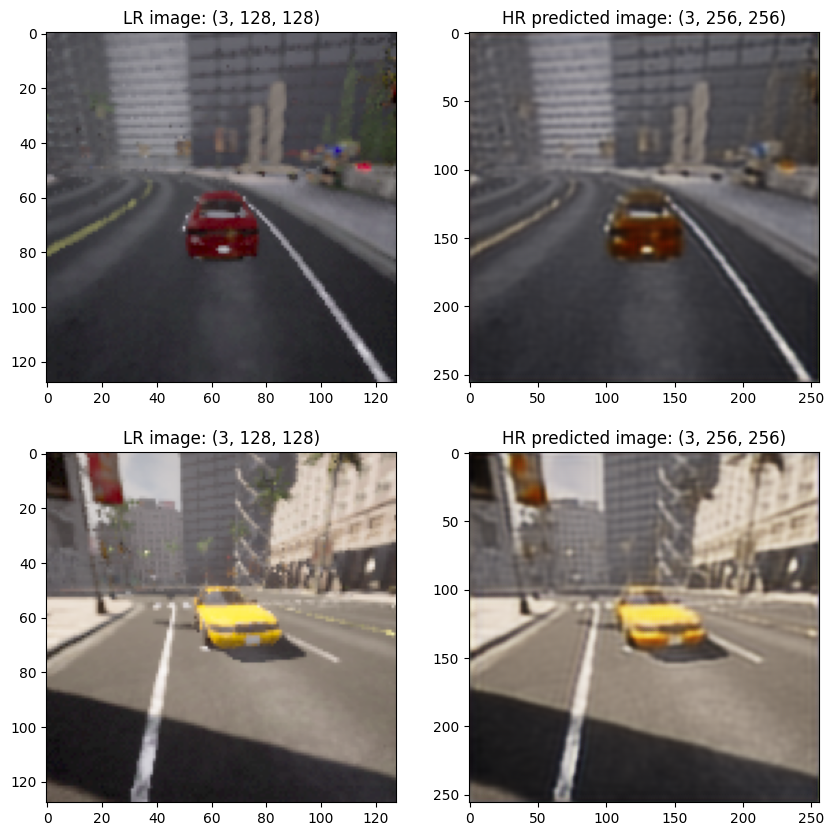

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
test_low_res1, _ = X_valid[np.random.randint(len(X_valid))]
test_low_res2, _ = X_valid[np.random.randint(len(X_valid))]
pred_high_res1 = exp1.net(test_low_res1.to(device))[0]
pred_high_res2 = exp1.net(test_low_res2.to(device))[0]
ex = [test_low_res1, pred_high_res1, test_low_res2, pred_high_res2]
for i, ax in enumerate(axes.flat):
    if i%2 == 0:
        ax.set_title(f'LR image: {ex[i].detach().cpu().numpy().shape}')
    else:
         ax.set_title(f'HR predicted image: {ex[i].detach().cpu().numpy().shape}')
    myimshow(ex[i], ax=ax)